In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def graphRes(act, pred):
    ax = plt.gca()
    for pos in positions:
        ax.scatter(act[pos],pred[pos], label=f'{pos} ({r2_score(act[pos], pred[pos]).round(2)})')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels)
    ax.plot(act['QB'],act['QB'],color='black') # y==x reference line
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def printStats(y_dev, y_pred):
    graphRes(y_dev, y_pred)

    stats = pd.DataFrame(index = [positions], columns = ['MAE','RMSE','R^2'])
    for pos in positions:
        stats.loc[pos,'MAE'] = mean_absolute_error(y_dev[pos], y_pred[pos]).round(1)
        stats.loc[pos,'RMSE'] = round(math.sqrt(mean_squared_error(y_dev[pos], y_pred[pos])),1)
        stats.loc[pos,'R^2'] = r2_score(y_dev[pos], y_pred[pos]).round(2)
    
    display(stats)
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [3]:
# Partition training, dev, and test data
positions = ['QB','RB','WR','TE']
X_train, X_dev, X_test = {}, {}, {}
y_train, y_dev, y_test = {}, {}, {}
data = {}
for pos in positions:
    Xy = pd.read_csv(f'../{pos}.csv').dropna(subset=['fanPts'])
    data[pos] = Xy
    X = Xy.loc[:,Xy.columns.str.contains('-\d+') | Xy.columns.str.match('fanPts')] \
        .drop('fanPts',axis=1) \
        .fillna(0)
    y = Xy.fanPts
    
    # Split
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=0)
    X_dev_raw, X_test_raw, y_dev_raw, y_test_raw = train_test_split(X_test_raw, y_test_raw, test_size=0.5, random_state=0)
    
    # Scale X data
    ss = preprocessing.StandardScaler()
    X_train[pos] = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
    X_dev[pos] = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
    X_test[pos] = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)
    
    # Leave y data in original units
    y_train[pos] = y_train_raw
    y_dev[pos] = y_dev_raw
    y_test[pos] = y_test_raw

QB: 0.4869843299400498 oob score
RB: 0.36455959530329607 oob score
WR: 0.4120795618190225 oob score
TE: 0.4077952192230845 oob score


,MAE,RMSE,R^2
QB,66.200,81.000,0.300
RB,42.800,62.800,0.400
WR,35.500,52.900,0.450
TE,23.800,32.500,0.370


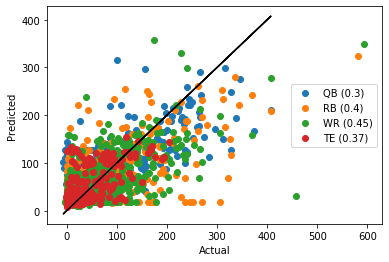

In [4]:
y_pred = {}
for pos in positions:
    m = m = RandomForestRegressor(oob_score = True)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    print(f'{pos}: {m.oob_score_} oob score')
    
printStats(y_dev, y_pred)

QB: 0.48356866051707614 oob score
{'max_depth': 9, 'n_estimators': 500}

RB: 0.3750272265040149 oob score
{'max_depth': 7, 'n_estimators': 80}

WR: 0.4154502707579383 oob score
{'max_depth': 3, 'n_estimators': 20}

TE: 0.4054236631090411 oob score
{'max_depth': 9, 'n_estimators': 40}



,MAE,RMSE,R^2
QB,65.600,79.600,0.320
RB,43.400,62.300,0.410
WR,36.300,53.400,0.440
TE,23.000,31.600,0.410


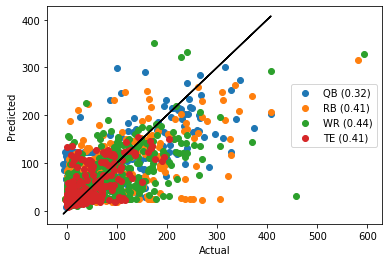

In [5]:
y_pred = {}
bestParams = {}
for pos in positions:
    
    grid = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid = {
            'max_depth': range(1,10),
            'n_estimators': tuple(list(range(10,100,10)) + [500, 1000]),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1).fit(X_train[pos],y_train[pos])
    
    bestParams[pos] = grid.best_params_
    
    rfr = RandomForestRegressor(max_depth=bestParams[pos]["max_depth"], n_estimators=bestParams[pos]["n_estimators"], oob_score = True, random_state=False, verbose=False)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    print(f'{pos}: {m.oob_score_} oob score')
    print(f'{bestParams[pos]}\n')
    
printStats(y_dev,y_pred)